### Modelos Discretos de depredador - presa
# Proyecto final por Rodolfo Trillo, Carolina López, Miguel Raz Guzmán

In [79]:
Pkg.add("LsqFit")
using PyPlot, LaTeXStrings, TaylorSeries, LsqFit

include("AutomDiff_V2.jl")
import AD: Dual, xdual

INFO: Cloning cache of LsqFit from https://github.com/JuliaOpt/LsqFit.jl.git
INFO: Installing LsqFit v0.0.2
INFO: Building Rmath
INFO: Package database updated
INFO: Recompiling stale cache file /home/mrg/.julia/lib/v0.5/TaylorSeries.ji for module TaylorSeries.

Use "Dict(a=>b for (a,b) in c)" instead.

Use "Dict(a=>b for (a,b) in c)" instead.


LoadError: LoadError: could not open file /home/mrg/8vo/ProyectoFinalBenet/AutomDiff_V2.jl
while loading In[79], in expression starting on line 4

In [91]:
#Pkg.add("PyPlot");
#Pkg.add("Combinatorics");
#Pkg.add("StatsBase");
#Pkg.add("DataFrames")
#Pkg.add("Gadfly")
#Pkg.add("Plots");
#Pkg.update();

# Todas las funciones grandes dentro de este programa tienen buenos docs. No los dejes solos...
using PyPlot, Gadfly, StatsBase, Combinatorics,Plots;

### Iniciando el campo de juego
Simulación de un mundo discreto de depredador - presa discreto

In [3]:
#0.1 Iniciar constantes y arreglos

const NGridSize = 12 :: Int        #Tamaño de Matriz
const TotalTurns = 100 :: Int #Turnos de tiempo global

const α = .5                       #Coeficiente de clon de presa

const β = .5                       #Coeficiente de clon de depredador
const ϵ_inicial = -3 :: Int               #Energia inicial para cada clon de depredador
const Δϵ = 1 :: Int                #Perdida de energia por paso de tiempo

const γ = .1                       #Porcentaje a hacer update en cada turno
const ρ_1 = .333                   #Densidad de presas
const ρ_2 = .333                   #Densidad de depredadores

#0.2 Construir matriz
const items = [-3,-2,-1,0,1]
const weights = [ρ_1 /3, ρ_1 /3, ρ_1 /3, 1-ρ_1-ρ_2, ρ_2]

# Chulada 1 con paquete StatsBase
Grid = reshape(sample(items,WeightVec(weights),NGridSize^2, replace=true)  ,NGridSize,NGridSize) ::Array{Int,2}

12×12 Array{Int64,2}:
  0   0   1  -2   1   1   1   1   1  -2   1   1
  1  -1   1  -2  -1  -3   0  -3   0   1  -2   0
  0  -1   0  -2   1  -2   0   1  -3   1  -1  -1
  1   1  -1  -3   0   0   0  -3   1   1   1   0
  0   0   0   1   1   1   1   1  -2  -3   0  -1
 -2   0  -3   0   0   0   1  -2   0  -2   0   1
 -1   0   0   1  -2   1   1  -3   0   0  -2   1
  0  -3   0  -2   0   1  -3  -3   0   1  -2  -2
 -3   1   0   1  -1   0  -1   1  -1  -3   0   1
 -2   0   1   0   0   0  -3   1  -3  -1  -3   1
  1   1  -1  -1  -3   0   1   1  -1  -3  -2  -1
  1   1  -1   1  -1  -3   1  -1   0   1   1   1

### Reglas de comportamiento

A considerar:

Si es presa
1. Si se puede mover
2. Si se clona

Si es depredador
1. Si puede mover
2. Si come
3. Si se clona

Consideraciones "amables":
- Fronteras toroidales
- Vecinos a distancia 1
- ¿Si puede comer el lobo, come?
- ¿Quién juega primero?

In [4]:
"""
check_vecinos_vacios(Row::Int,Col::Int)

Esta función revisa si en un vecindario de las 8 casillas adyacentes a una entrada en la matriz de Grid
existe al menos un solo vecino vacío. El código toma en cuenta los casos donde la frontera es toroidal.
Ejemplo:
```julia
julia> a=eye[2,2]
julia> check_vecinos_vacios(1,1)
1
julia> check_vecinos_vacios(1,2)
0
"""
function check_vecinos_vacios(Row::Int,Col::Int,Grid::Array{Int,2},NGridSize::Int)
    YSouth = mod(Row,NGridSize)+1
    XWest = mod(Col,  NGridSize) +1
    XEast = mod(Col-2,  NGridSize) +1
    YNorth = mod(Row-2, NGridSize) +1
    
    if Grid[YNorth, Col]== 0 ||Grid[Row, XEast]==0 ||
    Grid[Row, XWest]==0 || Grid[YSouth, Col]==0 ||
    Grid[YNorth,XEast]==0 || Grid[YNorth,XWest]==0 ||
    Grid[YSouth,XEast]==0 || Grid[YSouth,XWest]== 0
        return 1
    
    else return 0
    end
end

"""
check_comer_depredador(Row::Int,Col::Int,Grid::Array{Int,2})

Esta función revisa si en un vecindario de las 8 casillas aledañas a la entrada (Row,Col) existe al menos
una presa, y regresa un 1 en dado caso, 0 c.o.c. El código toma en cuenta el caso donde la frontera es toroidal.
julia> a=eye[2,2]
julia> check_comer_depredador(1,1)
1
julia> b = zeros[2,2]
julia> check_comer_depredador[1,1]
0
"""
function check_comer_depredador(Row::Int,Col::Int,Grid::Array{Int,2},NGridSize::Int)
    
    if Grid[Row,Col] == 0 || Grid[Row,Col] == 1
        return 0
    end
    
    
    YSouth = mod(Row,NGridSize)+1
    XWest = mod(Col,  NGridSize) +1
    XEast = mod(Col-2,  NGridSize) +1
    YNorth = mod(Row-2, NGridSize) +1
    
    if Grid[YNorth, Col] > 0 || Grid[Row, XEast] > 0 || Grid[Row, XWest] > 0 ||  Grid[YSouth,Col] > 0 || Grid[YNorth,XEast] > 0 || Grid[YNorth,XWest] > 0 || Grid[YSouth,XEast] > 0 ||  Grid[YSouth,XWest] > 0
        return 1
    else return 0
    end
end

"""
check_mover_depredador(Row::Int,Col::Int,Grid::Array{Int,2})

Esta función revisa si en un vecindario de las 8 casillas aledañas a la entrada (Row,Col) existe al menos
un movimiento posible para el depredador, y regresa un 1 en dado caso, 0 c.o.c. El código toma en cuenta el caso donde la frontera es toroidal.
julia> a=eye[2,2]
julia> check_mover_depredador(1,1)
1
julia> b = zeros[2,2]
julia> check_comer_depredador[1,1]
0
"""
function check_mover_depredador(Row::Int,Col::Int,Grid::Array{Int,2},NGridSize::Int)
    YSouth = mod(Row,NGridSize)+1
    XWest = mod(Col,  NGridSize) +1
    XEast = mod(Col-2,  NGridSize) +1
    YNorth = mod(Row-2, NGridSize) +1
    
    if Grid[Row,Col] != 0 || Grid[YNorth, Col] >= 0 || Grid[Row, XEast] >= 0 || Grid[Row, XWest] >= 0 ||  Grid[YSouth,Col] >= 0 || Grid[YNorth,XEast] >= 0 || Grid[YNorth,XWest] >= 0 || Grid[YSouth,XEast] >= 0 || Grid[YSouth,XWest] >= 0
        return 1
    else return 0
        
    end
end

check_mover_depredador


### Consideraciones "amables":
- Fronteras toroidales 
    - yup
- Vecinos a distancia 1 
    - yup
- ¿Si puede comer el lobo, come?
    - yup
- ¿Quién juega primero?
    - presa
- ¿Energía de clon de depredador es independiente a si come?
    - yup
- ¿Tope de energía para depredador?
    - yup
- ¿Cuál es la distribución inicial de energía para los lobos?
    - Uniforme, desde la inicial

In [5]:
#Movimiento de presas

"""
moviendo_presa(Row::Int,Col::Int,Grid::Array{Int,2},NGridSize::Int,α::Float64)

Esta función establece el comportamiento de la presa.Si una
presa en (Row,Col) puede moverse a una casilla aledaña, lo haráy si
se clona con probabilidad α.

"""

function moviendo_presa(Row::Int,Col::Int,Grid::Array{Int,2},NGridSize::Int,α::Float64)
    #Sanity check
    if Grid[Row,Col] <= 0
        return 0 
    end
    
    if check_vecinos_vacios(Row,Col,Grid,NGridSize) == 1
        
        #Coeficiente de clonado - a veces deja una Dolly en su lugar...
        rand() < α ? clon = 1 : clon = 0
        
        #Chulada 2 - Fronteras toroidales en cuadrícula. 
        #Considerar usar la función mod1()
        #Con estas defs podemos revisar valores de vecinos.
        YSouth = mod(Row,NGridSize)+1
        XWest = mod(Col,  NGridSize) +1
        XEast = mod(Col-2,  NGridSize) +1
        YNorth = mod(Row-2, NGridSize) +1
        
        #Gran ciclo para intentar moverse a una casilla no ocupada.
        for i in 1:50
        
        #Oh...
        behave = rand(1:1:8)
            
        #Checando que nuestros vecinos sean movidas permitidas
        if behave == 1 && Grid[YNorth,XWest] == 0
            Grid[YNorth,XWest] = 1
            Grid[Row,Col] = clon
                break
        elseif behave == 2 && Grid[YNorth,Col] == 0
            Grid[YNorth,Col] = 1
            Grid[Row,Col] = clon
                break
        elseif behave == 3 && Grid[YNorth,XEast] == 0
            Grid[YNorth,XEast] = 1 
            Grid[Row,Col] = clon
                break
        elseif behave == 4 && Grid[Row,XWest] == 0
            Grid[Row,XWest] = 1
            Grid[Row,Col] = clon
                break
        elseif behave == 5 && Grid[Row,XEast] == 0
            Grid[Row,XEast] = 1
            Grid[Row,Col] = clon
                break
        elseif behave == 6 && Grid[YSouth,XWest] == 0
            Grid[YSouth,XWest] = 1
            Grid[Row,Col] = clon
                break
        elseif behave == 7 && Grid[YSouth,Col] == 0
            Grid[YSouth,Col] = 1
            Grid[Row,Col] = clon
                break
        elseif behave == 8 && Grid[YSouth,XEast] == 0
            Grid[YSouth,XEast] = clon
            Grid[Row,Col] = clon
                break
        
            end
        end
    end
end

            
"""
moviendo_depredador(Row::Int,Col::Int,Grid::Array{Int,2},NGridSize::Int,β::Float64)

Establece reglas de comportamiento para el depredador en (Row,Col). Si puede comer a una presa
aledaña, preferirá comer y moverse a sólo moverse. Se puede reproducir con
probabilidad β.
"""

#Movimiento de depredadores
function moviendo_depredador(Row::Int,Col::Int,Grid::Array{Int,2},NGridSize::Int,β::Float64)
    
    #Sanity check
    if Grid[Row,Col] >= 0
        return 0
    end
    
    puede_moverse = 0
    puede_comer = 0
    
    #Verificamos que se puedan mover
    puede_moverse = check_mover_depredador(Row,Col,Grid,NGridSize)
    puede_comer   = check_comer_depredador(Row,Col,Grid,NGridSize)
    
    prioridad = puede_moverse + puede_comer
        
    #Asignamos condicional a la ϵ_depredador si puede comer. Esta es la ϵ que se queda el
    # "original", per se. 
    if puede_comer == 1
        Grid[Row,Col] = ϵ_inicial
        else 
        Grid[Row,Col] = Grid[Row,Col] + Δϵ
    end
    
    #Starvation check
    if Grid[Row,Col] >= 0 
        return 0
    end
    
    ϵ_depredador = Grid[Row,Col]
    clon = 0::Int
    
    if check_mover_depredador(Row,Col,Grid,NGridSize) == 1
        
        #Coeficiente de clonado
        rand() < β ? clon = ϵ_inicial : clon = 0
        
        #Otra vez definimos a las casillas vecinas en fronteras toroidales
        YSouth = mod(Row,NGridSize)+1
        XEast = mod(Col,  NGridSize) +1
        XWest = mod(Col-2,  NGridSize) +1
        YNorth = mod(Row-2, NGridSize) +1
                
        #Con puro colmillo no ponemos un while por si las dudas...
        for i in 1:50
        
        behave = rand(1:1:8)
            
            # Chulada 3 - La segunda condicional impera que si puede comer y moverse, debe comer cuando se mueve.
            # ¿Ves cómo?
            if behave == 1 && Grid[YNorth,XWest] == puede_comer
                    Grid[YNorth,XWest] = ϵ_depredador
                    Grid[Row,Col] = clon    
                    break
                elseif behave == 2 && Grid[YNorth,Col] == puede_comer
                    Grid[YNorth,Col] = ϵ_depredador
                    Grid[Row,Col] = clon
                    break
                elseif behave == 3 && Grid[YNorth,XEast] == puede_comer
                    Grid[YNorth,XEast] = ϵ_depredador 
                    Grid[Row,Col] = clon
                    break
                elseif behave == 4 && Grid[Row,XWest] == puede_comer
                    Grid[Row,XWest] = ϵ_depredador
                    Grid[Row,Col] = clon
                    break
                elseif behave == 5 && Grid[Row,XEast] == puede_comer
                    Grid[Row,XEast] = ϵ_depredador
                    Grid[Row,Col] = clon
                    break
                elseif behave == 6 && Grid[YSouth,XWest] == puede_comer
                    Grid[YSouth,XWest] = ϵ_depredador
                    Grid[Row,Col] = clon
                    break
                elseif behave == 7 && Grid[YSouth,Col] == puede_comer
                    Grid[YSouth,Col] = ϵ_depredador
                    Grid[Row,Col] = clon
                    break
                elseif behave == 8 && Grid[YSouth,XEast] == puede_comer
                    Grid[YSouth,XEast] = ϵ_depredador 
                    Grid[Row,Col] = clon
                    break
            
            end
        end
    end
end

 

moviendo_depredador

### ¿Pifa?

In [6]:
NGridSize = 5;Grid = eye(Int,5,5); Grid[2,2] = -3; Grid

5×5 Array{Int64,2}:
 1   0  0  0  0
 0  -3  0  0  0
 0   0  1  0  0
 0   0  0  1  0
 0   0  0  0  1

In [7]:
moviendo_presa(4,4,Grid,NGridSize,.9)
Grid

5×5 Array{Int64,2}:
 1   0  0  0  0
 0  -3  0  0  0
 0   0  1  0  1
 0   0  0  1  0
 0   0  0  0  1

In [8]:
ϵ_inicial = -3
Δϵ = 1

moviendo_depredador(2,2,Grid,NGridSize, 0.)
Grid

5×5 Array{Int64,2}:
 -3  0  0  0  0
  0  0  0  0  0
  0  0  1  0  1
  0  0  0  1  0
  0  0  0  0  1

### The Big Loop!

In [50]:
#Super Gran Loop

"""
BigLoop(NGridSize::Int64, α::Float64, β::Float64, ϵ_inicial::Int64, Δϵ::Int64, γ::Float64, ρ_1::Float64, ρ_2::Float64, TurnTimer::Int64)

Esta función toma una familia de parámetros para simular un microcosmos de depredadores y presas en una matriz con
fronteras toroidales. Regresa los arreglos Presas, Depredadores, Turnos, Grid para poder graficarlos.
Primero define sus arreglos y coordenadas, empieza contadores, y luego en un gran loop de iteración evoluciona
los agentes de cambio con mover_depredador() y mover_presa(), para despues contar a los sobrevivientes y push! a arreglos.

"""
function BigLoop(
    
    NGridSize::Int,
    α::Float64,
    β::Float64,
    ϵ_inicial :: Int,
    Δϵ :: Int,
    γ :: Float64,
    ρ_1 :: Float64,
    ρ_2 :: Float64, 
    TurnTimer::Int,)
    #######################
    
    #Iniciar Matriz
    Espacio_Coordenadas = [(x,y) for x=1:NGridSize, y=1:NGridSize]
    items_0 = [-3,-2,-1,0,1]
    weights_0 = [ρ_1 /3, ρ_1 /3, ρ_1 /3, 1-ρ_1-ρ_2, ρ_2]
    Grid = reshape(sample(items_0,WeightVec(weights_0),NGridSize^2, replace=true),NGridSize,NGridSize) ::Array{Int,2}
    
    # Iniciar contadores y randomseed (para que sea replicable los resultados)
    srand(1234)
    iter=enumerate(Grid)
    Presas = [0]
    Depredadores = [0]
    Turnos = [0]
    
    #Chulada 4 del paquete de Combinatorics
    presas_vivas = count(iter->(iter>0), Grid)
    depredadores_vivos = count(iter->(iter<0), Grid)
    
    #Listos para pushear y graficar...
    push!(Presas,presas_vivas)
    push!(Depredadores, depredadores_vivos)
    
    #Variable auxiliar para recorrer sampleo
    tope = convert(Int,round(γ*NGridSize^2))   
    turn_counter = 0
    #The Big Loop-de-Loop!
    
    
    @inbounds for time_step in 1:TurnTimer


        #Ojo, esto se alenta en matrices esparsas...por...?
        aux = sample(Espacio_Coordenadas,tope;replace=false) :: Array{Tuple{Int64,Int64},1}
       
        #Chulada 5 con reinterpret y vector - Como convertir tuplas en arreglos
        sampleo = vec(reinterpret(Int, aux, (1,tope*2)))
        turn_counter += 1
        
        @inbounds for i in 1:tope*2-1

            Row,Col = sampleo[i], sampleo[i+1]

            # Who moves first? :D
            # Si las entradas no son una casilla vacía, entonces la registramos en todos nuestros
            # Arreglos, si no, simplemente se lo salta
            if Grid[Row,Col] != 0 
                #Movemos a las presas o depredadores
                moviendo_presa(Row,Col,Grid,NGridSize,α)
                moviendo_depredador(Row,Col,Grid,NGridSize,β)

            end
        end
                #Contamos a los vivos                
                presas_vivas = count(iter->(iter>0), Grid)
                depredadores_vivos = count(iter->(iter<0), Grid)
                #Guardamos cuantos vivos hay
                push!(Presas,presas_vivas)
                push!(Depredadores, depredadores_vivos)
                #Guardamos el turno
                push!(Turnos, turn_counter)
    end
    
    print("\n Simulation complete! \n!")
    return Presas,Depredadores,Turnos, Grid
    
end
    
    
    

BigLoop

### Simulando...

In [ ]:
const NGridSize = 12 :: Int        #Tamaño de Matriz
const TurnTimer = 100 :: Int       #Turnos de tiempo global

const α = .7                       #Coeficiente de clon de presa

const β = .3                       #Coeficiente de clon de depredador
const ϵ_inicial = -3::Int              #Energia inicial para cada clon de depredador
const Δϵ = 1 :: Int                #Perdida de energia por paso de tiempo

const γ = .2                       #Porcentaje a hacer update en cada turno
const ρ_1 = .333                   #Densidad de presas
const ρ_2 = .333                   #Densidad de depredadores
#######################################


Presas, Depredadores, Turnos,Result_Grid = BigLoop(NGridSize,α,β,ϵ_inicial,Δϵ,γ,ρ_1,ρ_2,TurnTimer)
presas = Presas[end]; depredadores = Depredadores[end]; turno = Turnos[end]

im = imshow(Result_Grid)
title("Población de presas y depredadores en un mundo toroidal")
################


 Simulation complete! 
!

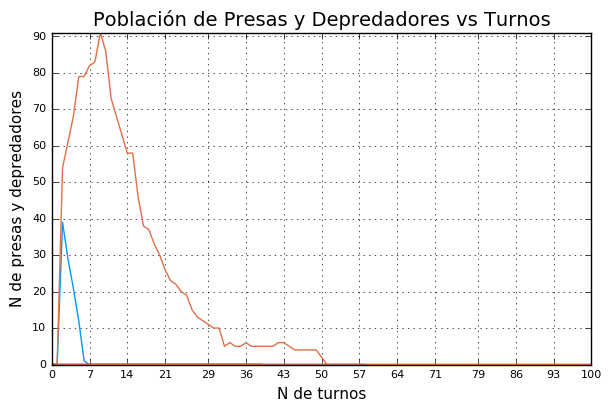

INFO: Saved animation to /home/mrg/8vo/ProyectoFinalBenet/tmp.gif


Plots.AnimatedGif("/home/mrg/8vo/ProyectoFinalBenet/tmp.gif")

In [53]:
p = Plots.plot([Presas,Depredadores],zeros(0),leg=true)
title!("Población de Presas y Depredadores vs Turnos")
yaxis!("N de presas y depredadores",0:TurnTimer/10:TurnTimer)
xaxis!("N de turnos", 0:1:TurnTimer)

anim = Animation()
@gif for x in 1:1:TurnTimer
    push!(p,x,Int[Presas[x],Depredadores[x]])
    frame(anim)
end

In [ ]:
const NGridSize = 12 :: Int        #Tamaño de Matriz
const TurnTimer = 100 :: Int       #Turnos de tiempo global

const α = .8                       #Coeficiente de clon de presa

const β = .05                       #Coeficiente de clon de depredador
const ϵ_inicial = -3::Int              #Energia inicial para cada clon de depredador
const Δϵ = 1 :: Int                #Perdida de energia por paso de tiempo

const γ = .2                       #Porcentaje a hacer update en cada turno
const ρ_1 = .333                   #Densidad de presas
const ρ_2 = .333                   #Densidad de depredadores
#######################################


Presas, Depredadores, Turnos,Result_Grid = BigLoop(NGridSize,α,β,ϵ_inicial,Δϵ,γ,ρ_1,ρ_2,TurnTimer)
presas = Presas[end]; depredadores = Depredadores[end]; turno = Turnos[end]

im = imshow(Result_Grid)
title("Población de presas y depredadores en un mundo toroidal")
################


 Simulation complete! 
!

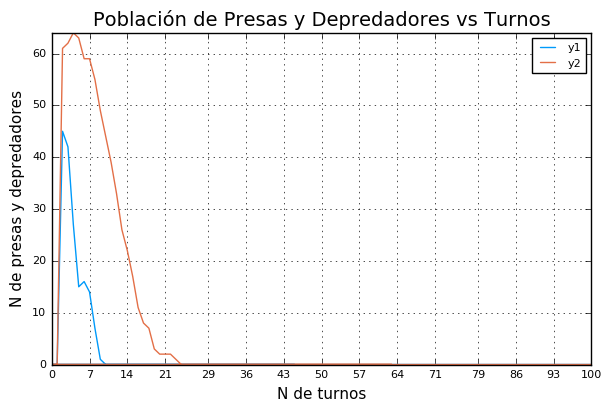

INFO: Saved animation to /home/mrg/8vo/ProyectoFinalBenet/tmp.gif


Plots.AnimatedGif("/home/mrg/8vo/ProyectoFinalBenet/tmp.gif")

In [58]:
p = Plots.plot([Presas,Depredadores],zeros(0),leg=true)
title!("Población de Presas y Depredadores vs Turnos")
yaxis!("N de presas y depredadores",0:TurnTimer/10:TurnTimer)
xaxis!("N de turnos", 0:1:TurnTimer)

anim = Animation()
@gif for x in 1:1:TurnTimer
    push!(p,x,Int[Presas[x],Depredadores[x]])
    frame(anim)
end

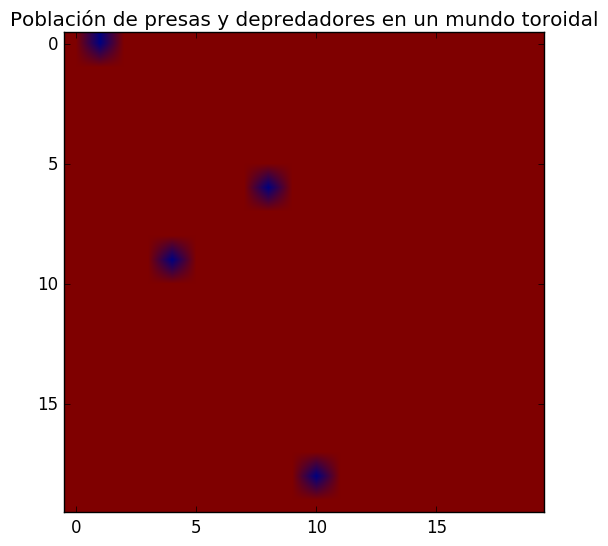


 Simulation complete! 
!

PyObject <matplotlib.text.Text object at 0x7f1e3f685710>

In [81]:
const NGridSize = 20 :: Int        #Tamaño de Matriz
const TurnTimer = 100 :: Int       #Turnos de tiempo global

const α = .9                       #Coeficiente de clon de presa

const β = .0123                      #Coeficiente de clon de depredador
const ϵ_inicial = -2::Int              #Energia inicial para cada clon de depredador
const Δϵ = 1 :: Int                #Perdida de energia por paso de tiempo

const γ = .2                       #Porcentaje a hacer update en cada turno
const ρ_1 = .333                   #Densidad de presas
const ρ_2 = .1                     #Densidad de depredadores
#######################################


Presas, Depredadores, Turnos,Result_Grid = BigLoop(NGridSize,α,β,ϵ_inicial,Δϵ,γ,ρ_1,ρ_2,TurnTimer)
presas = Presas[end]; depredadores = Depredadores[end]; turno = Turnos[end]

im = imshow(Result_Grid)
title("Población de presas y depredadores en un mundo toroidal")
################

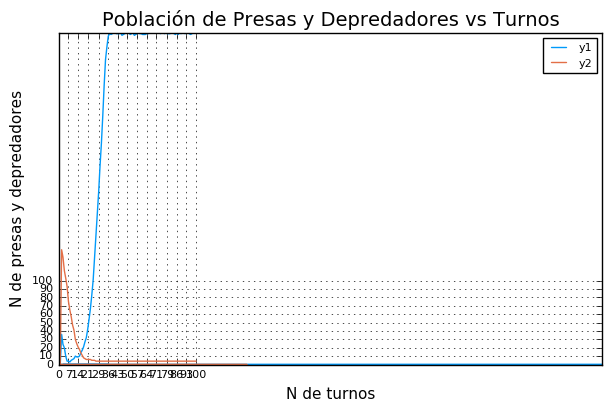

INFO: Saved animation to /home/mrg/8vo/ProyectoFinalBenet/tmp.gif


Plots.AnimatedGif("/home/mrg/8vo/ProyectoFinalBenet/tmp.gif")

In [82]:
p = Plots.plot([Presas,Depredadores],zeros(0),leg=true)
title!("Población de Presas y Depredadores vs Turnos")
yaxis!("N de presas y depredadores",0:TurnTimer/10:TurnTimer)
xaxis!("N de turnos", 0:1:TurnTimer)

anim = Animation()
@gif for x in 1:1:TurnTimer
    push!(p,x,Int[Presas[x],Depredadores[x]])
    frame(anim)
end

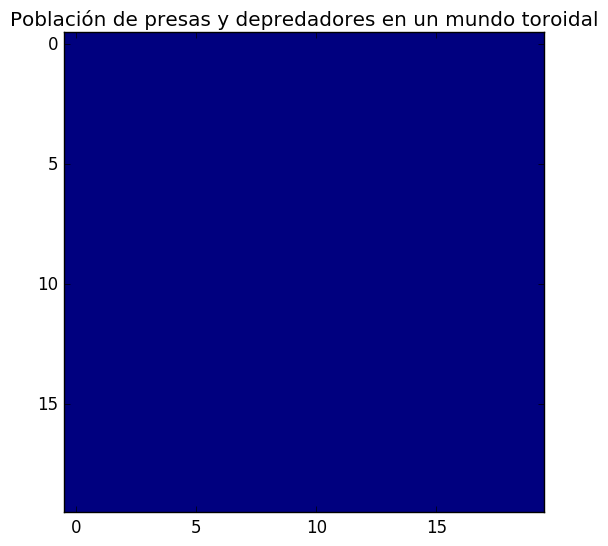


 Simulation complete! 
!

PyObject <matplotlib.text.Text object at 0x7f1e42615890>

In [89]:
const NGridSize = 20 :: Int        #Tamaño de Matriz
const TurnTimer = 300 :: Int       #Turnos de tiempo global

const α = .6                       #Coeficiente de clon de presa

const β = .02                       #Coeficiente de clon de depredador
const ϵ_inicial = -5::Int              #Energia inicial para cada clon de depredador
const Δϵ = 1 :: Int                #Perdida de energia por paso de tiempo

const γ = .2                       #Porcentaje a hacer update en cada turno
const ρ_1 = .333                   #Densidad de presas
const ρ_2 = .2                   #Densidad de depredadores
#######################################


Presas, Depredadores, Turnos,Result_Grid = BigLoop(NGridSize,α,β,ϵ_inicial,Δϵ,γ,ρ_1,ρ_2,TurnTimer)
presas = Presas[end]; depredadores = Depredadores[end]; turno = Turnos[end]

im = imshow(Result_Grid)
title("Población de presas y depredadores en un mundo toroidal")
################

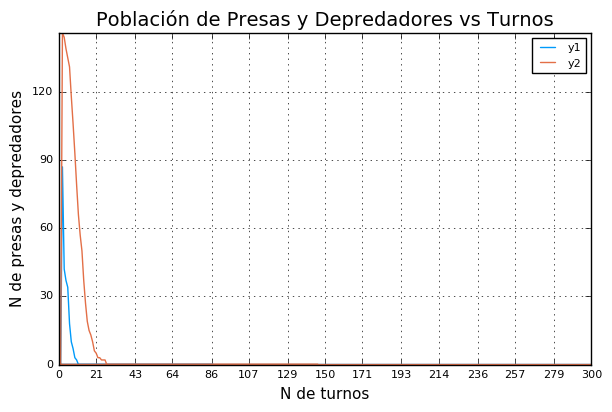

INFO: Saved animation to /home/mrg/8vo/ProyectoFinalBenet/tmp.gif


Plots.AnimatedGif("/home/mrg/8vo/ProyectoFinalBenet/tmp.gif")

In [90]:
p = Plots.plot([Presas,Depredadores],zeros(0),leg=true)
title!("Población de Presas y Depredadores vs Turnos")
yaxis!("N de presas y depredadores",0:TurnTimer/10:TurnTimer)
xaxis!("N de turnos", 0:1:TurnTimer)

anim = Animation()
@gif for x in 1:1:TurnTimer
    push!(p,x,Int[Presas[x],Depredadores[x]])
    frame(anim)
end

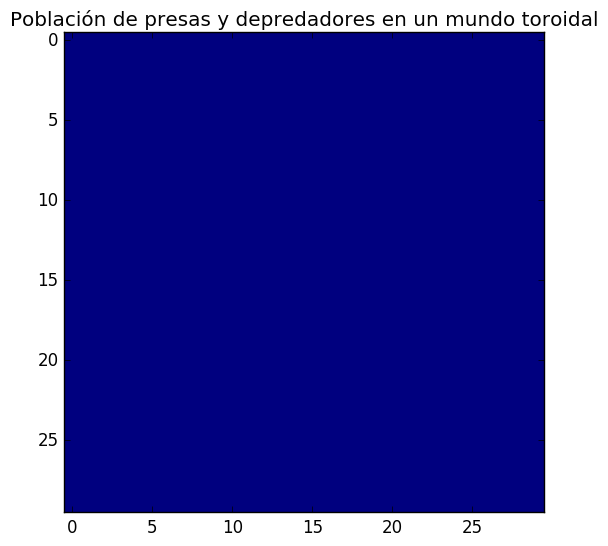


 Simulation complete! 
!

PyObject <matplotlib.text.Text object at 0x7f1e45538c10>

In [86]:
const NGridSize = 30 :: Int        #Tamaño de Matriz
const TurnTimer = 100 :: Int       #Turnos de tiempo global

const α = .8                       #Coeficiente de clon de presa

const β = .02                       #Coeficiente de clon de depredador
const ϵ_inicial = -3::Int              #Energia inicial para cada clon de depredador
const Δϵ = 1 :: Int                #Perdida de energia por paso de tiempo

const γ = .2                       #Porcentaje a hacer update en cada turno
const ρ_1 = .8                     #Densidad de presas
const ρ_2 = .1                   #Densidad de depredadores
#######################################


Presas, Depredadores, Turnos,Result_Grid = BigLoop(NGridSize,α,β,ϵ_inicial,Δϵ,γ,ρ_1,ρ_2,TurnTimer)
presas = Presas[end]; depredadores = Depredadores[end]; turno = Turnos[end]

im = imshow(Result_Grid)
title("Población de presas y depredadores en un mundo toroidal")
################

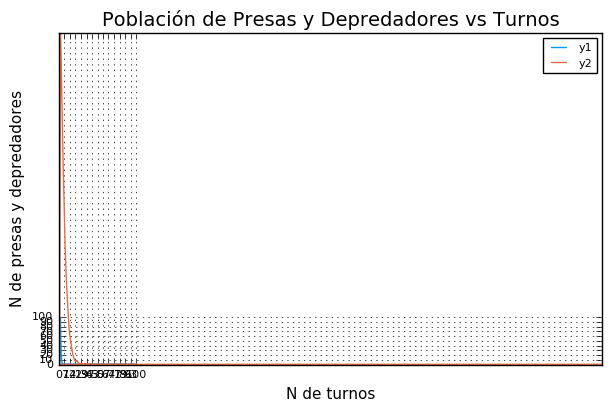

INFO: Saved animation to /home/mrg/8vo/ProyectoFinalBenet/tmp.gif


Plots.AnimatedGif("/home/mrg/8vo/ProyectoFinalBenet/tmp.gif")

In [87]:
p = Plots.plot([Presas,Depredadores],zeros(0),leg=true)
title!("Población de Presas y Depredadores vs Turnos")
yaxis!("N de presas y depredadores",0:TurnTimer/10:TurnTimer)
xaxis!("N de turnos", 0:1:TurnTimer)

anim = Animation()
@gif for x in 1:1:TurnTimer
    push!(p,x,Int[Presas[x],Depredadores[x]])
    frame(anim)
end

### Bibliografía
 Wilenskz, Reisman,2006. "Thinking Like a Wolf, a Sheep, or a Firefly:Learning Biology Through Constructing and Testing Computational Theories--an Embodied Modeling Approach", http://ccl.northwestern.edu/papers/wolfsheep.pdf